### ИНФО

Имеется исходник с различными оценками асессоров.

Формат исходника: 
- login — логин асессора
- uid — id асессора (user id)
- docid — id оцениваемого документа (document id)
- jud — оценка асессора (judgement)
- cjud — правильная оценка (correct judgement)

разделитель — табуляция \t.

Оценки могут принимать значение [0, 1], т.е. задание, которое сделали асессоры, имеет бинарную шкалу.
Используя данные об оценках, установите, какие асессоры хуже всего справились с заданием. На какие показатели вы ориентировались и какие метрики вы использовали для ответа на этот вопрос? Можно ли предложить какие-то новые метрики для подсчета качества асессоров с учетом природы оценок у этого бинарного задания?

### ИМПОРТ ИНСТРУМЕНТОВ

In [150]:
import pandas as pd
import numpy as np

### ОЗНАКОМЛЕНИЕ С ДАННЫМИ

In [151]:
db=pd.read_csv(r'C:\Users\devba\Documents\DataScience\Vacancies\файл 2.csv',sep='\t')

In [152]:
db.sample(10)

,login,uid,docid,jud,cjud
103770,assessor374,374,20754,0,0
119030,assessor40,40,23806,1,1
61443,assessor75,75,12288,0,0
90905,assessor178,178,18181,0,0
39013,assessor490,490,7802,0,0
202782,assessor443,443,40556,0,0
184248,assessor580,580,36849,0,0
83883,assessor493,493,16776,0,1
7054,assessor479,479,1410,0,0
221031,assessor354,354,44206,0,0


In [153]:
db.shape

(250000, 5)

In [154]:
db.uid.nunique()

600

In [155]:
db.docid.nunique()

50000

In [156]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   login   250000 non-null  object
 1   uid     250000 non-null  int64 
 2   docid   250000 non-null  int64 
 3   jud     250000 non-null  int64 
 4   cjud    250000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 9.5+ MB


в таблице 250 000 строк, пропусков информации нет
в таблице присутствуют данные об оценках 600 асессоров, которые оценивали 50 000 уникальных документов

### ГЕНЕРАЦИЯ НОВЫХ ДАННЫХ

In [184]:
'''создадим новый столбец, который будет оценивать верна ли оценка асессора или нет
0 - оценка асессора была неверна
1 - оценка асессора была верна

возможны 4 варианта: 
    jud     cjud
    0        0
    1        1
    1        0
    0        1
    
в первых двух случаях в новый столбец запишется значение "1", в 3 и 4 случаях: 0'''

db['conclusion']=(db.jud+db.cjud)/2
db.cocnlusion=db.conclusion.replace(0,1,inplace=True)
db.cocnlusion=db.conclusion.replace(0.5,0,inplace=True)

### АНАЛИЗ И УМОЗАКЛЮЧЕНИЕ

In [186]:
# Среднее от результатов покажет насколько асессор был эффективен в своих оценках. 
# Чем больше среднее, тем больше у него было правильных оценок (1), и тем он более эффективен
performance_stat=db.groupby('uid').conclusion.mean().round(2).sort_values(ascending=False)
performance_stat

uid
63     0.92
151    0.92
184    0.92
38     0.92
528    0.92
       ... 
390    0.48
118    0.48
234    0.48
3      0.46
56     0.43
Name: conclusion, Length: 600, dtype: float64

In [187]:
performance_stat.describe()

count    600.000000
mean       0.840767
std        0.055506
min        0.430000
25%        0.810000
50%        0.830000
75%        0.890000
max        0.920000
Name: conclusion, dtype: float64

Видим, что при стандартном отклонении = 0.056 и медиане 0.83 минимальное значение в нашем столбце ю 0.43. Очевидно присутствую выбросы. Проверим

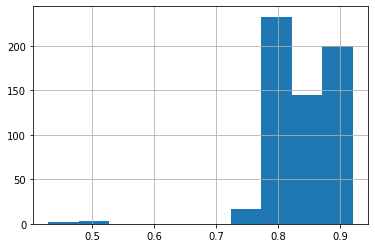

In [188]:
performance_stat.hist()

выбросы действительно присутствуют, вычислив их мы как раз и найдем тех асессоров, кто хуже всего справился с заданием

In [191]:
#функция для отбрасывания выбросов

def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3-Q1
    l_boundary=Q1-1.5*IQR
    h_boundary=Q3+1.5*IQR
    
    outliers = column[~column.between(l_boundary, h_boundary)]
    n_outl=outliers.count()
    p_outl=np.round(n_outl*100/len(db),2)
    print('Minor boundries are ({},{})\n There are {} or {}% outlying values'\
          .format(l_boundary,h_boundary,n_outl,p_outl))
    
    inp=input('Clear outliers?\n Input Y (for yes) or N (for no): ')
    
    if inp=='Y': 
        if (type(l_boundary)==int)|(type(l_boundary)==np.float64):
            column=column[column.between(l_boundary, h_boundary)]
        else: 
            column=column[column.between(str(l_boundary), str(h_boundary))]
    else: 
        column=column
    
    return column

Minor boundries are (0.6900000000000002,1.01)
 There are 5 or 0.0% outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


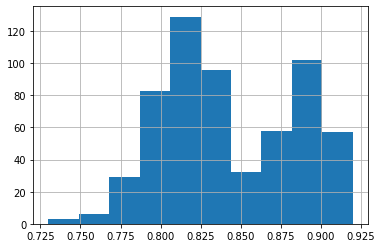

In [190]:
outliers(performance_stat).hist()

Из полученного следует, что все значения performance_stat, которые были ниже 0.725 являлись статистическими выбросами и были отфильтрованы.

In [163]:
performance_stat[performance_stat<0.725]

uid
390    0.48
118    0.48
234    0.48
3      0.46
56     0.43
Name: conclusion, dtype: float64

Умозаключение : Хуже всего с оценкой справились асессоры uid3, uid56, uid118, uid234, uid390, так как их результаты слишком сильно отличаются от общей картины

#### дополнительная идея

При ознакомлении с документом, было выявлено, что наши данные содержат информацию о раоте 600 асессоров над 50 000 документов, при этом записей в таблице - 250 000. Это указывает на то, что один и тот же документ подавался на проверку нескольким асессорам. Проверим:

In [168]:
db.groupby('docid').conclusion.count().describe()

count    50000.0
mean         5.0
std          0.0
min          5.0
25%          5.0
50%          5.0
75%          5.0
max          5.0
Name: conclusion, dtype: float64

Выяняется, что каждый из 50 000 документов проверялся 5-ью различными асессорами. 
По каждому из них нам известен результат: асессор ошибся или был прав. В вводных данных ничего не говорилось об однотипности документов, следовательно, если сопоставить два документа по числу ошибшихся асессоров, то можно будет сделать косвенный вывод о сложности документа. Этот коэфициент можно далее использовать в качестве веса при оценке результативности отдельного асессора. Т.е, если показатели  performance_stat двух асессоров, равны, например 0.81 и 0.79 соответственно, но при этом второму попадались более сложные документы на оценку, то весовой коэфициент как раз поможет выявить такие ситуации.  

In [202]:
doc_diff=1-db.groupby('docid').conclusion.sum()/5
doc_diff.sort_values(ascending=False)

docid
2906     1.0
9457     1.0
34709    1.0
41326    1.0
25274    0.8
        ... 
26678    0.0
26685    0.0
26686    0.0
26688    0.0
0        0.0
Name: conclusion, Length: 50000, dtype: float64

Чем выше полученный коэфициент, тем сложнее документ для проверки (больше асессоров оценили его неправильно), а следовательно ценнее асессор, правильно оценивший такие документы.

Далее надо добавить столбец 'doc_diff' в нашу таблицу, где перед каждым документом будет стоять оценка его сложности, а также performance_stat_weighted, рассчитанный не просто как среднее от от колонки conclusion, a как среднее от (conclusion x doc_diff). Полученные показатели будут отражать эффективность асессоров с учетом сложности проверяемых ими заданий. 